The purpose of this project is to identify elements in student writing.  
More specifically, automatically segment texts and classify argumentative and rhetorical elements in essays written by 6th-12th grade students.  
This in turn can make it easier for students to receive feedback on their writing and increase opportunities to improve writing outcomes.   
Virtual writing tutors and automated writing systems can leverage these algorithms while teachers may use them to reduce grading time.
 <center></center>
 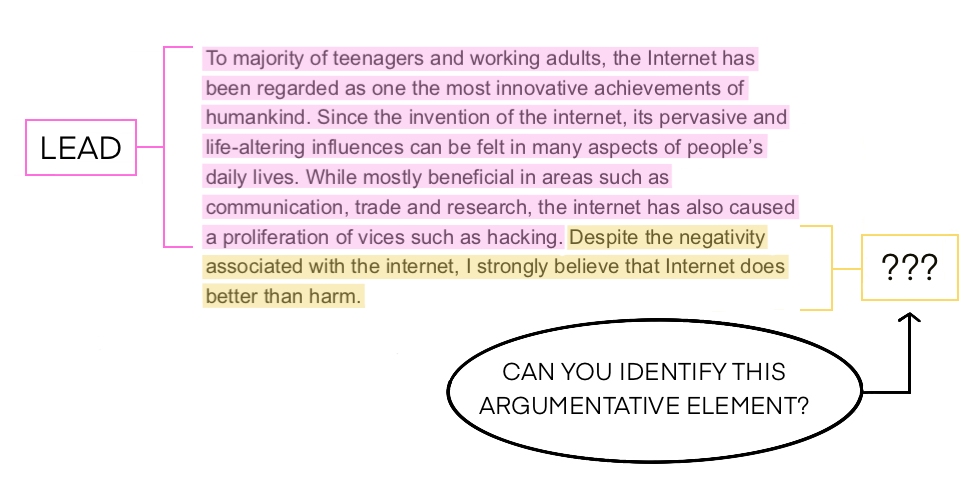

---
<center><h1>Configuration & Imports</h1></center>

In [ ]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE. 
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

# VERSION FOR SAVING/LOADING MODEL WEIGHTS
# THIS SHOULD MATCH THE MODEL IN LOAD_MODEL_FROM
VER=1 

# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
# LOAD_TOKENS_FROM = '../input/tf-longformer-v12'
LOAD_TOKENS_FROM = None

# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
# LOAD_MODEL_FROM = '../input/tflongformerv14'
LOAD_MODEL_FROM = None

# IF FOLLOWING IS NONE, THEN NOTEBOOK 
# USES INTERNET AND DOWNLOADS HUGGINGFACE 
# CONFIG, TOKENIZER, AND MODEL
# DOWNLOADED_MODEL_PATH = '../input/tf-longformer-v12'
DOWNLOADED_MODEL_PATH = None

if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'    
MODEL_NAME = 'allenai/longformer-base-4096'

INPUT_PATH = '../input/feedback-prize-2021/'
CSV_FILE = "train.csv"
TRAIN_CSV_PATH = INPUT_PATH + CSV_FILE
TRAIN_PATH = INPUT_PATH + 'train/'
TEST_PATH = INPUT_PATH + 'test/'
MODEL_PATH = 'model'
BAR = '--------------------------------------------------------------'

<h3>Import Libraries</h3>

In [ ]:
import pandas as pd, numpy as np
import random
from spacy import displacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
print('TF version',tf.__version__)

<h3>Single or Mirrored Strategy</h3>

In [ ]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

In [ ]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

---
<center><h1> Exploratory Data Analysis </h1></center>

<h3>Read csv file and sample it</h3>

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH)
print("Number of discourse anottations =", df.shape[0])
df.head()

<h3>Summary of column info & type</h3>

In [ ]:
df.info()

<h3>Presense of NaNs:</h3>

In [ ]:
df.isnull().sum()

train.csv contains no nulls.

<h3>Number of articles</h3>
How many articles are mentioned in the train.csv?

In [ ]:
id_list, num_articles = df['id'].unique(),df['id'].nunique()
print(f"There are {num_articles} unique articles in train.csv.")

Verify number of unique articles is the same as actual article text files:

In [ ]:
# all text files
txt_list = os.listdir(TRAIN_PATH)
txt_list_stripped = [l[:-4] for l in txt_list] # strip .txt 
ids = list(df['id'])
# Verify text files match to csv
try:
    assert(set(txt_list_stripped)==set(ids))
    print(f"Number of unique articles is the same as actual article text files")
except AssertionError:
    print(f"Number of unique articles is --NOT-- the same as actual article text files")

<h3> Unique discourse types </h3>
All unique discourse types:

In [ ]:
discourse_types = list(df['discourse_type'].unique())
print(discourse_types)
num_unique_discourse = len(discourse_types)

<h3> Visualize several articles with displacy </h3>
let's visualize several articles with the appropriate discourse annotations:

In [ ]:
color_dict = {
            'Lead': '#f39b79',
            'Position': '#2f8ceb',
            'Evidence': '#00ff95',
            'Claim': '#962fbf',
            'Rebuttal': '#ff0000',
            'Counterclaim': '#fff59b',
            'Concluding Statement': '#fa7e1e'        
         }

def construct_entities(df, chosen_id):
    """ Constructs entity list for the specified article ID"""
    
    ents = []
    for index,row in df.query("id == @chosen_id").iterrows():
        ents.append({
                'start': int(row['discourse_start']), 
                'end': int(row['discourse_end']), 
                'label': row['discourse_type']
                    })
    return ents

def visualize(chosen_id):
    """Displays discourses for specified article ID"""
    
    ents = construct_entities(df, chosen_id)
    with open(TRAIN_PATH + chosen_id + '.txt', 'r') as file: 
        data = file.read()

    doc = {
        "text": data,
        "ents": ents,
        "title": chosen_id
    }

    options = {"ents": discourse_types, "colors": color_dict}
    displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

In [ ]:
random_articles = random.choices(ids, k=3)
for article in random_articles:
    visualize(article)
    print(BAR)

Some insights from visual inspection:
- There are words not belonging to any of the discourse types.
- A discourse could start in the middle of the sentence, so punctuation isn't always a delimiter.
- Not all articles have all the discourse types.

<h3>Distribution of number of  discourse types per article</h3>

In [ ]:
def annotate(splot, total_size, precision, percentage='on'):
  """Helper function to annotate graphs"""
  k = {'on':100/total_size, 'off': 1}
  for p in splot.patches:
    splot.annotate(format(k[percentage]*p.get_height(),f'.{precision}f') + '%',
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 10),
                  textcoords = 'offset points')

In [ ]:
sns.set(style="darkgrid", context="talk",rc={'figure.figsize':(11.7,8.27)})
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

In [ ]:
df_eda = df[['id','discourse_type']].drop_duplicates().groupby(by='id').size().reset_index(name='counts')
splot = sns.countplot(x='counts', data=df_eda)
annotate(splot, df_eda.shape[0], 1, percentage='on')
plt.title('Distribution of number of discourse types per article', fontsize=30);

We see that only 14.5% of all articles have all of the discourse types.  
About 2/3 of the articles have 4 or 5 discourse types.

<h3>Discource type present at least once in article distribution</h3>  
<h3>Discource type count distribution per article</h3>

In [ ]:
df_eda = df[['id','discourse_type']].groupby(by=['id','discourse_type']).size().reset_index(name='counts')
discourse_types = list(df['discourse_type'].unique())

lst = []

fig, ax = plt.subplots(4,2, figsize=(25,16))
fig.suptitle('Discourse count per article distributions',fontsize=20)
for index in range(len(discourse_types)):
  i,j = index //2, index %2
  dis_type = discourse_types[index]
  df_a = df_eda[df_eda['discourse_type'] == dis_type]
  lst.append(df_a.shape[0])
  splot = sns.countplot(ax=ax[i,j],x='counts', data=df_a)
  ax[i,j].set_title(f"{dis_type} count per article distribution",fontsize=15)
  annotate(splot, df_a.shape[0],2, percentage='on')
fig.tight_layout()
fig.subplots_adjust(top=0.94);

splot = sns.barplot(x=discourse_types, y=lst)
annotate(splot, num_articles,2, percentage='on')
plt.title('discourse appearance percentage distribution', fontsize=15);

We notice from the last graph:  
1. Position, claim and Evidence appear in more than 95% of the articles.
2. Most of the articles don't have rebuttal or claim , thus most of the articles are "one-sided".

From the rest of the graphs we conclude:
1. Lead, Position, Concluding statement in almost all cases appear once. This suggets that vast majority of the articles deal with one topic.
2. We also notice that claim and evidence have a more diverse distribution, with median = 3 per article:

<h3>Text Length Distribution of Texts Filtered by the Discourses</h3>

In [ ]:
df_a = df['discourse_text'].groupby(df['id']).transform(lambda x: ' '.join(x)).drop_duplicates().str.len()

In [ ]:
sns.displot(df_a,color='r', aspect=2)
plt.title("discourse-based text length distribution", fontsize=30)
plt.xlabel('text length')
plt.show()

<h3>Discourse length distribution per each discourse type</h3>

In [ ]:
df['discourse_length'] = df['discourse_text'].str.len()
df_a = df.groupby('discourse_type')['discourse_length'].median().sort_values(ascending=False)
splot = sns.barplot(y=df_a.index, x=df_a.values)
plt.title('discourse length distribution per each discourse type', fontsize=30)
plt.xlabel('median text length')
plt.show()

We notice that evidence is the dominant discourse from text length prespective, while claim & position are the shortest.

<h3>Discourse Position Tendency</h3>

In [ ]:
df_a = df.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(
    by = 'discourse_start', 
    ascending = False)
df_a.plot(x='discourse_type',
        kind='barh',
        figsize=(10,8))
plt.title('Average start and end position of discourse',fontsize=30 )
plt.show()

<h3>n-grams analysis</h3>

In [ ]:
def get_n_grams(n_grams, top_n = 10):
    
    df_words = pd.DataFrame()
    
    for dt in discourse_types:
        
        df_a = df[df['discourse_type']==dt]
        texts = df_a['discourse_text'].tolist()
        vec = CountVectorizer(lowercase = True, stop_words = 'english',\
                              ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq,\
                                            columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Discourse_type", dt)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
        
    return df_words

def plot_ngram(df, type = "unigrams"):
    
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Discourse_type.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most frequent {type} in {dt}")
        data = df.query('Discourse_type == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh', color = 'steelblue', legend=False)
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [ ]:
unigrams = get_n_grams(n_grams = 1, top_n=10)
plot_ngram(unigrams)

In [ ]:
bigrams = get_n_grams(n_grams = 2, top_n=10)
plot_ngram(bigrams,type='bigrams')

In [ ]:
trigrams = get_n_grams(n_grams = 3, top_n=10)
plot_ngram(trigrams, 'trigrams')

We notice the following:
1. The most popular unigrams are students, school and people in most of the discourses 
2. The most popular bigrams are electoral college, driverless cars in most of the discourses
3. trigrams are more diverse, they don't have a clear common most popular trigram in most of the discourses. 


---

<h1>Model creation & Tokenization</h1>

Create mapping dictionary from discourse type to unique number:

In [ ]:
zip_iterator = zip(discourse_types, range(len(discourse_types)))
target_map = dict(zip_iterator)
target_map

Instantiate a model & tokenzier if no model is available:

In [ ]:
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
    
    # instantiate a tokenizer & a model and save it 
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained('model')

    config = AutoConfig.from_pretrained(MODEL_NAME) 
    config.save_pretrained('model')

    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    backbone.save_pretrained('model')

<h3> Create target arrays </h3>

In [ ]:
MAX_NUM_TOKENS = 1024

# Instantiate token arrays for each article
train_tokens = np.zeros((num_articles,MAX_NUM_TOKENS), dtype='int32') # holds tokens for each article
train_attention = np.zeros((num_articles,MAX_NUM_TOKENS), dtype='int32') # --- attention masks ---

instantiate target arrays:

In [ ]:
# THE 14 CLASSES FOR NER
lead_b = np.zeros((num_articles,MAX_NUM_TOKENS))
lead_i = np.zeros((num_articles,MAX_NUM_TOKENS))

position_b = np.zeros((num_articles,MAX_NUM_TOKENS))
position_i = np.zeros((num_articles,MAX_NUM_TOKENS))

evidence_b = np.zeros((num_articles,MAX_NUM_TOKENS))
evidence_i = np.zeros((num_articles,MAX_NUM_TOKENS))

claim_b = np.zeros((num_articles,MAX_NUM_TOKENS))
claim_i = np.zeros((num_articles,MAX_NUM_TOKENS))

conclusion_b = np.zeros((num_articles,MAX_NUM_TOKENS))
conclusion_i = np.zeros((num_articles,MAX_NUM_TOKENS))

counterclaim_b = np.zeros((num_articles,MAX_NUM_TOKENS))
counterclaim_i = np.zeros((num_articles,MAX_NUM_TOKENS))

rebuttal_b = np.zeros((num_articles,MAX_NUM_TOKENS))
rebuttal_i = np.zeros((num_articles,MAX_NUM_TOKENS))

# HELPER VARIABLES
train_lens = []
targets_b = [lead_b, position_b, evidence_b, claim_b, conclusion_b, counterclaim_b, rebuttal_b]
targets_i = [lead_i, position_i, evidence_i, claim_i, conclusion_i, counterclaim_i, rebuttal_i]

fill targets_b & targets_i arrays:

In [ ]:
# LOOP THROUGH EACH TRAIN TEXT
num_of_actual_tokens = [] # holds actual number of tokens for each article
for count in range(num_articles):
    if LOAD_TOKENS_FROM: break
    
    if count%1000==0: print("number of articles for which target_b & target_i "\
                            f"arrays were updated: {count}")
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    chosen_id = id_list[count]
    txt_path = TRAIN_PATH + f'{chosen_id}.txt'
    with open(txt_path, 'r') as f:
        txt = f.read()

    train_lens.append( len(txt.split()))
    
#     Tokenize text file
    tokens = tokenizer.encode_plus(txt, max_length=MAX_NUM_TOKENS, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    num_of_actual_tokens.append(np.array(tokens['attention_mask']).sum())
    train_tokens[count,] = tokens['input_ids']
    train_attention[count,] = tokens['attention_mask']
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets_list = tokens['offset_mapping']
    token_number = 0
    df_id = df.query("id == @chosen_id")
    for index,row in df_id.iterrows():                     # iterate over discourses
        discourse_start = row.discourse_start
        discourse_end = row.discourse_end
        if token_number>MAX_NUM_TOKENS-1:                  # if we reach last token after completing last discourse
            break
        offset_start = offsets_list[token_number][0]
        offset_end = offsets_list[token_number][1]
        first_token_discourse = True
        while discourse_end>offset_start:                  # while token belongs to current discourse
            if (offset_start>=discourse_start)&(discourse_end>=offset_end): # if token inside discourse 
                k = target_map[row.discourse_type]         # get unique number 
                if first_token_discourse:                  # if the first token inside discourse
                    targets_b[k][count][token_number] = 1  # [discourse_type][count of article][token number]
                    first_token_discourse = False          # next tokens inside discourse are _i
                else:
                    targets_i[k][count][token_number] = 1  # not first token in discourse-> fill _i
            token_number += 1                              # continue to next token
            if token_number>MAX_NUM_TOKENS-1:              # if we reach last token before reaching the end of discourse
                break
            offset_start, offset_end = offsets_list[token_number] # update offsets for next token

Token count distribution:

In [ ]:
plt.hist(num_of_actual_tokens,bins=60)
plt.title('Histogram of Token Counts',size=16)
plt.xlabel('Token Count',size=14)
plt.show()

In [ ]:
truncated_percentage = 100 *(np.array(num_of_actual_tokens) == MAX_NUM_TOKENS).sum() / num_articles
print(f"Truncated articles percentage due to token number limit = {truncated_percentage:.2f}%")

Create unified target array if doesn't exist:

In [ ]:
num_labels = num_unique_discourse*2+1
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((num_articles,MAX_NUM_TOKENS,num_labels), dtype='int32')
    for k in range(num_unique_discourse):
        targets[:,:,2*k] = targets_b[k]      # [count of article][token number][b/i]
        targets[:,:,2*k+1] = targets_i[k]    
    targets[:,:,num_labels-1] = 1-np.max(targets,axis=-1)

In [ ]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_NUM_TOKENS}', targets)
    np.save(f'tokens_{MAX_NUM_TOKENS}', train_tokens)
    np.save(f'attention_{MAX_NUM_TOKENS}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_NUM_TOKENS}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_NUM_TOKENS}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_NUM_TOKENS}.npy')
    print('Loaded NER tokens')

<h3>Build Model</h3>

In [ ]:
def build_model():
    
    tokens = tf.keras.layers.Input(shape=(MAX_NUM_TOKENS,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_NUM_TOKENS,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json') 
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.25e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()

<h2>Train validation Split</h2>

In [ ]:
# TRAIN VALID SPLIT 90% 10%
TEST_SIZE = 0.1
np.random.seed(42)
train_idx = np.random.choice(np.arange(num_articles),int(0.9*num_articles),replace=False)
valid_idx = np.setdiff1d(np.arange(num_articles),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))

<h2>Train Model / Load Existing Model</h2>

<h3>Training parameters:</h3>

In [ ]:
# LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 1
BATCH_SIZE = 4 
# LRS = [0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-5] 
LRS = [0.25e-4] 
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

Load or train model:

In [ ]:
# LOAD MODEL
if LOAD_MODEL_FROM:
    model.load_weights(f'{LOAD_MODEL_FROM}/long_v{VER}.h5')
    
# OR TRAIN MODEL
else:
    model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
          y = targets[train_idx,],
          validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                             targets[valid_idx,]),
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          verbose = 2)

    # SAVE MODEL WEIGHTS
    model.save_weights(f'long_v{VER}.h5')

In [ ]:
 model.load_weights(f'model/long_v{VER}.h5')

In [ ]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
print('OOF predictions shape:',p.shape)
oof_preds = np.argmax(p,axis=-1)

In [ ]:
def get_preds(dataset='train', verbose=True, text_ids=id_list[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
    
        # GET ID
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
    
        # GET TOKEN POSITIONS IN CHARS
        name = INPUT_PATH + f'{dataset}/{n}.txt'
        txt = open(name, 'r').read()
        tokens = tokenizer.encode_plus(txt, max_length=MAX_NUM_TOKENS, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
    
        # GET WORD POSITIONS IN CHARS
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(txt[i]!='\xa0')&(txt[i]!='\x85')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n')|(txt[i]=='\xa0')|(txt[i]=='\x85'):
                blank=True
        w.append(1e6)
            
        # MAPPING FROM TOKENS TO WORDS
        word_map = -1 * np.ones(MAX_NUM_TOKENS,dtype='int32')
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        
        # CONVERT TOKEN PREDICTIONS INTO WORD LABELS
        ### KEY: ###
        # 0: LEAD_B, 1: LEAD_I
        # 2: POSITION_B, 3: POSITION_I
        # 4: EVIDENCE_B, 5: EVIDENCE_I
        # 6: CLAIM_B, 7: CLAIM_I
        # 8: CONCLUSION_B, 9: CONCLUSION_I
        # 10: COUNTERCLAIM_B, 11: COUNTERCLAIM_I
        # 12: REBUTTAL_B, 13: REBUTTAL_I
        # 14: NOTHING i.e. O
        ### NOTE THESE VALUES ARE DIVIDED BY 2 IN NEXT CODE LINE
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_NUM_TOKENS:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_NUM_TOKENS: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_NUM_TOKENS: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    # MAKE DATAFRAME
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    
    return df

In [ ]:
oof = get_preds( dataset='train', verbose=True, text_ids=id_list[valid_idx] )
oof.head()

In [ ]:
print('The following classes are present in oof preds:')
oof['class'].unique()

In [ ]:
# CODE FROM : Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [ ]:
# VALID DATAFRAME
valid = train.loc[train['id'].isin(IDS[valid_idx])]

In [ ]:
f1s = []
CLASSES = oof['class'].unique()
for c in CLASSES:
    pred_df = oof.loc[oof['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

Infer Test Data:

In [ ]:
f1s = []
CLASSES = oof['class'].unique()
for c in CLASSES:
    pred_df = oof.loc[oof['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

In [ ]:
# CONVERT TEST TEXT TO TOKENS
test_tokens = np.zeros((len(TEST_IDS),MAX_NUM_TOKENS), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_NUM_TOKENS), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'../input/feedback-prize-2021/test/{n}.txt'
    txt = open(name, 'r').read()
    tokens = tokenizer.encode_plus(txt, max_length=MAX_NUM_TOKENS, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [ ]:
# INFER TEST TEXTS
p = model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)
print('Test predictions shape:',p.shape)
test_preds = np.argmax(p,axis=-1)

In [ ]:
# GET TEST PREDICIONS
sub = get_preds( dataset='test', verbose=False, text_ids=TEST_IDS, preds=test_preds )
sub.head()